In [242]:
# Section 1
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import re
# from nltk.corpus import stopwords

nltk.download('punkt')

#Create a Finnish instance
stemmer = SnowballStemmer("finnish")

# Function to remove stopwords, punctuation, numbers, and check if the keyword is in the text
def preprocess_text(text):
    text = str(text)
    text = re.sub(r'http\S+', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [stemmer.stem(word) for word in tokens if (not any(char in word for char in string.punctuation)) and (word.lower() not in stopwords_list) and (not any(char.isdigit() for char in word))]
    return ' '.join(filtered_tokens)

def contains_keyword(text):
    text = str(text)
    tokens = word_tokenize(text)
    return any(translation in tokens for translation in translations)

# Download the Finnish stopwords list and save it as "finnish_stopwords.txt"
# Then load the stopwords from the file
with open('finnish_stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords_list = file.read().splitlines()

# Selected keywords
# selected_keyword = ["well-being", "happiness", "quality of life", "health"]
# translations = ["hyvinvointi", "vointi"]
translations = ["ilmastonmuutos"]
# translations = ["hyvinvointi", "vointi", "onnellisuus", "elämänlaatu", "terveys", "terveydentila"]
# translations = ["hyvinvointi", "vointi", "onnellisuus", "onni", "elämänlaatu", "terveys", "terveydentila"]
translations = [stemmer.stem(word) for word in translations]
# translations = translations + selected_keyword

filtered_threads_total = pd.DataFrame(columns=['title', 'thread_text', 'datetime'])

# Loop for reading from 2001 to 2020 dataset
for i in range(1, 21):
    # Load the CSV file into a DataFrame
    data_file_name = f'data/parsed_data_{i}.csv'
    df = pd.read_csv(data_file_name)

    # Filter out only threads
    threads_df = df[df['msg_type'] == 'thread_start']

    # Filter threads containing the keyword in title or thread_text
    threads_df.loc[:, 'thread_text'] = threads_df['thread_text'].apply(preprocess_text)
    threads_df.loc[:, 'title'] = threads_df['title'].apply(preprocess_text)
    threads_df.loc[:, 'datetime'] = pd.to_datetime(threads_df['datetime'])
    threads_df.dropna(inplace=True, how='any')
    filtered_threads = threads_df[threads_df['title'].apply(contains_keyword) | threads_df['thread_text'].apply(contains_keyword)]
    filtered_threads_total = pd.concat([filtered_threads_total, filtered_threads], ignore_index=True)
    print(f"{i} year of data processing finished!")
    
# Save the filtered results to a new CSV file
filtered_threads_total[['title', 'thread_text', 'datetime']].to_csv('data/filtered_threads_f3.csv', index=False)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aghaffar23\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


1 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


2 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


3 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


4 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


5 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


6 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


7 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


8 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


9 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


10 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


11 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


12 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


13 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


14 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


15 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


16 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


17 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


18 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


19 year of data processing finished!


C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\2059009036.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_df.dropna(inplace=True, how='any')


20 year of data processing finished!


In [253]:
#section 2

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Load the dataset
df = pd.read_csv('data/filtered_threads_f3.csv')

# Convert the 'datetime' column to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'])
df.dropna(inplace=True, how='any')

# Create a dictionary to store sub-datasets for each year
yearly_datasets = {}

# Loop through the dataset and separate data for each year
for year in range(2001, 2021):
    # Filter data for the current year using the dt.year attribute
    data_for_year = df[df['datetime'].dt.year == year]
    yearly_datasets[f'{year}'] = data_for_year

# Function to calculate vocabulary for each year
def get_vocabulary(data):
    vectorizer = CountVectorizer()
    vectorized = vectorizer.fit_transform(data)
    return vectorizer

# Create a dictionary to store the vocabulary for each year
vocabulary_by_year = {}
tokens_by_year = {}

# Calculate vocabulary for each year
for year, data in yearly_datasets.items():
    if data.empty:
        vocabulary_by_year[year] = 0
        tokens_by_year[year] = 0
        continue
    year_vocabulary = get_vocabulary(data['thread_text'])
    total_unique_vocab = len(year_vocabulary.vocabulary_)
    # To get the total vocabulary size, we sum the counts of all words in the vocabulary
    total_vocab_size = sum(year_vocabulary.fit_transform(data['thread_text']).sum(axis=0).tolist()[0])
    vocabulary_by_year[year] = total_unique_vocab
    tokens_by_year[year] = total_vocab_size

# Print or manipulate the vocabulary data as needed
for year, vocab_size in vocabulary_by_year.items():
    print(f"Year {year}: Vocabulary Size = {vocab_size}, Total Tokens = {tokens_by_year[year]}")


Year 2001: Vocabulary Size = 0, Total Tokens = 0
Year 2002: Vocabulary Size = 78, Total Tokens = 108
Year 2003: Vocabulary Size = 745, Total Tokens = 1219
Year 2004: Vocabulary Size = 2853, Total Tokens = 7675
Year 2005: Vocabulary Size = 4562, Total Tokens = 10283
Year 2006: Vocabulary Size = 15314, Total Tokens = 53768
Year 2007: Vocabulary Size = 17824, Total Tokens = 66641
Year 2008: Vocabulary Size = 17039, Total Tokens = 62184
Year 2009: Vocabulary Size = 13873, Total Tokens = 43210
Year 2010: Vocabulary Size = 11752, Total Tokens = 36011
Year 2011: Vocabulary Size = 8955, Total Tokens = 23165
Year 2012: Vocabulary Size = 5867, Total Tokens = 12469
Year 2013: Vocabulary Size = 5838, Total Tokens = 14827
Year 2014: Vocabulary Size = 5855, Total Tokens = 14470
Year 2015: Vocabulary Size = 6528, Total Tokens = 14243
Year 2016: Vocabulary Size = 6472, Total Tokens = 16788
Year 2017: Vocabulary Size = 5660, Total Tokens = 12339
Year 2018: Vocabulary Size = 8393, Total Tokens = 22606
Y

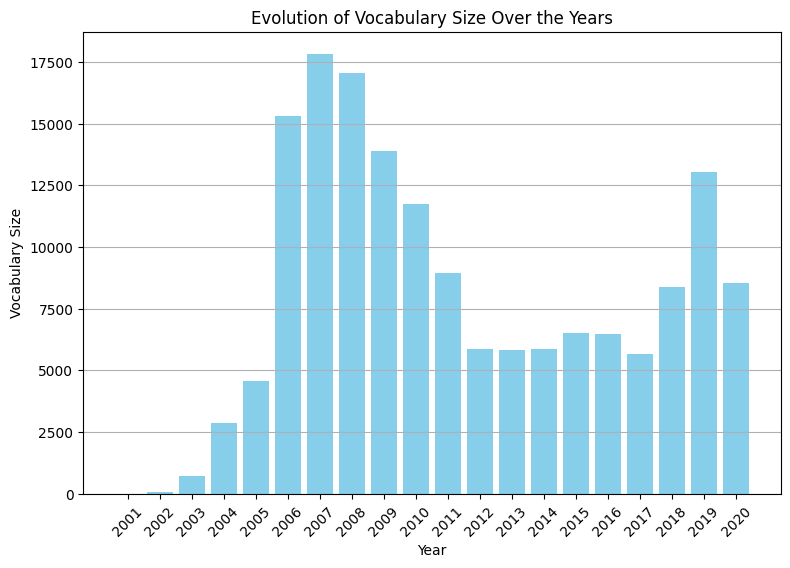

In [254]:
#Section3
import matplotlib.pyplot as plt

# Extract required data
years = list(vocabulary_by_year.keys())
vocab_sizes = [vocab for vocab in vocabulary_by_year.values()]

# Create a bar plot to show vocabulary evolution over the years
plt.figure(figsize=(9, 6))
plt.bar(years, vocab_sizes, color='skyblue')
plt.title('Evolution of Vocabulary Size Over the Years')
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Vocabulary Size')
plt.grid(axis='y')  # Only horizontal grid lines
plt.show()


c:\Users\aghaffar23\OneDrive - Oulun yliopisto\Work\Uni\Courses\NLP\codes\venv\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
c:\Users\aghaffar23\OneDrive - Oulun yliopisto\Work\Uni\Courses\NLP\codes\venv\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\aghaffar23\OneDrive - Oulun yliopisto\Work\Uni\Courses\NLP\codes\venv\Lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
C:\Users\aghaffar23\AppData\Local\Temp\ipykernel_16596\1191893409.py:57: RuntimeWarning: invalid value encountered in divide
  prediction_interval = t * std_err * np.sqrt(1 + 1 / n + (np.log(x) - np.mean(np.log(x))) ** 2 / ((n - 1) * np.var(np.log(x))))


2002 data processing for ploting done!
2003 data processing for ploting done!
2004 data processing for ploting done!
2005 data processing for ploting done!
2006 data processing for ploting done!
2007 data processing for ploting done!
2008 data processing for ploting done!
2009 data processing for ploting done!
2010 data processing for ploting done!
2011 data processing for ploting done!
2012 data processing for ploting done!
2013 data processing for ploting done!
2014 data processing for ploting done!
2015 data processing for ploting done!
2016 data processing for ploting done!
2017 data processing for ploting done!
2018 data processing for ploting done!
2019 data processing for ploting done!
2020 data processing for ploting done!
Year 2002, 80.0% Confidence: 0 points outside bounds
Year 2002, 85.0% Confidence: 0 points outside bounds
Year 2002, 90.0% Confidence: 0 points outside bounds
Year 2002, 95.0% Confidence: 0 points outside bounds


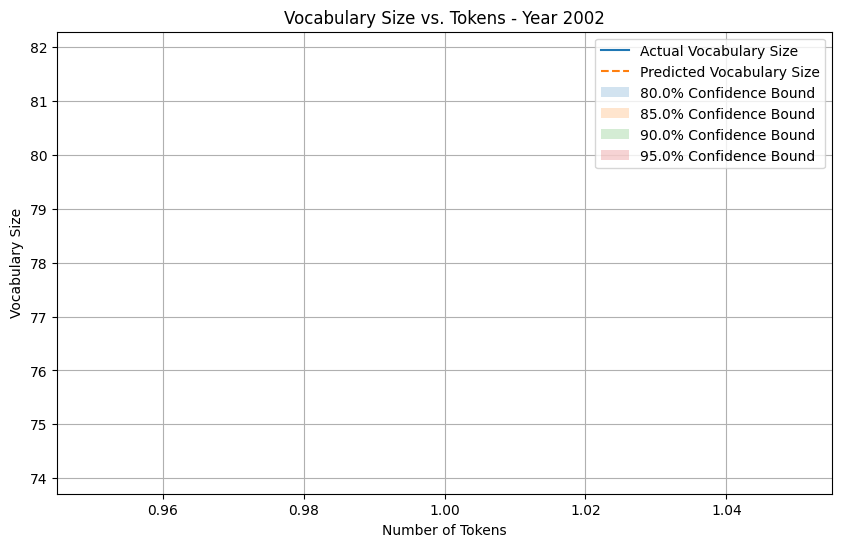

2002 plot done!
Year 2003, 80.0% Confidence: 0 points outside bounds
Year 2003, 85.0% Confidence: 0 points outside bounds
Year 2003, 90.0% Confidence: 0 points outside bounds
Year 2003, 95.0% Confidence: 0 points outside bounds


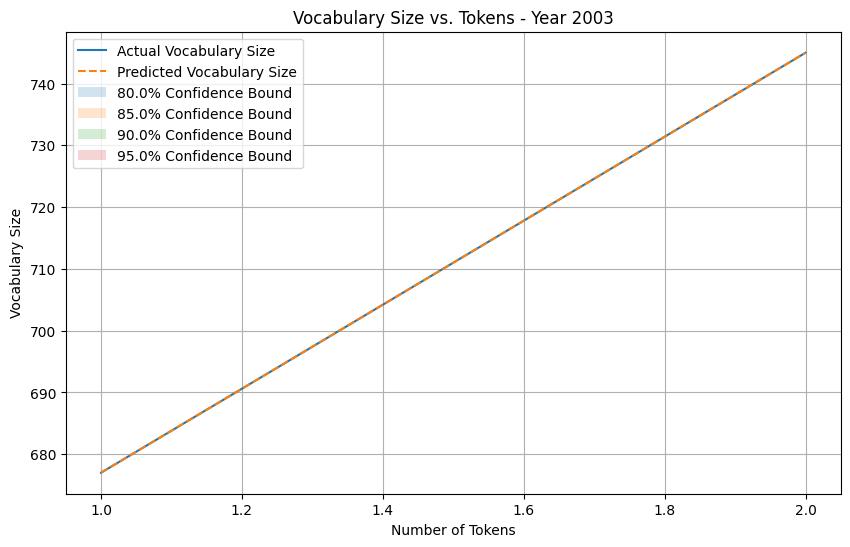

2003 plot done!
Year 2004, 80.0% Confidence: 12 points outside bounds
Year 2004, 85.0% Confidence: 11 points outside bounds
Year 2004, 90.0% Confidence: 10 points outside bounds
Year 2004, 95.0% Confidence: 6 points outside bounds


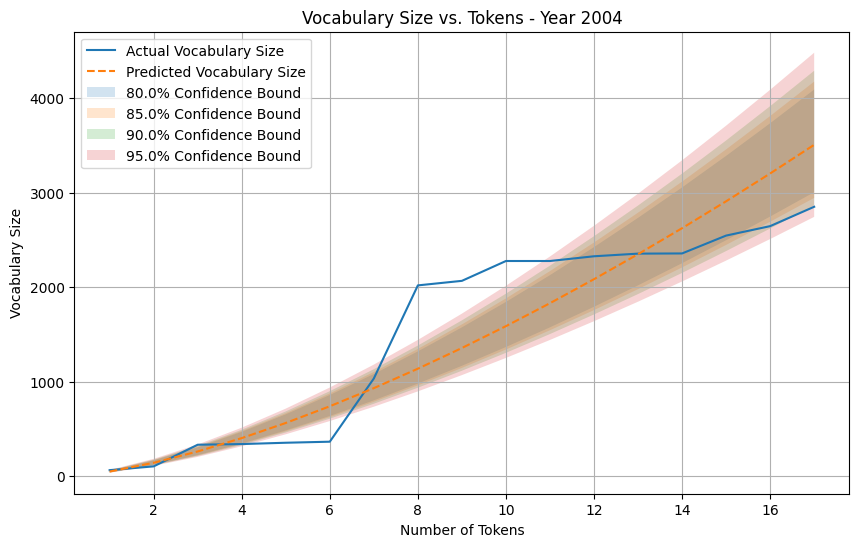

2004 plot done!
Year 2005, 80.0% Confidence: 51 points outside bounds
Year 2005, 85.0% Confidence: 50 points outside bounds
Year 2005, 90.0% Confidence: 49 points outside bounds
Year 2005, 95.0% Confidence: 47 points outside bounds


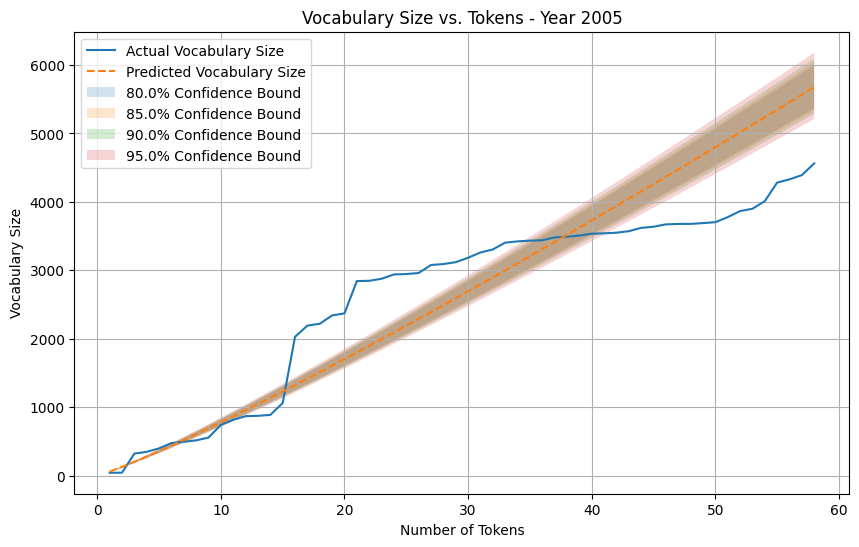

2005 plot done!
Year 2006, 80.0% Confidence: 134 points outside bounds
Year 2006, 85.0% Confidence: 134 points outside bounds
Year 2006, 90.0% Confidence: 132 points outside bounds
Year 2006, 95.0% Confidence: 130 points outside bounds


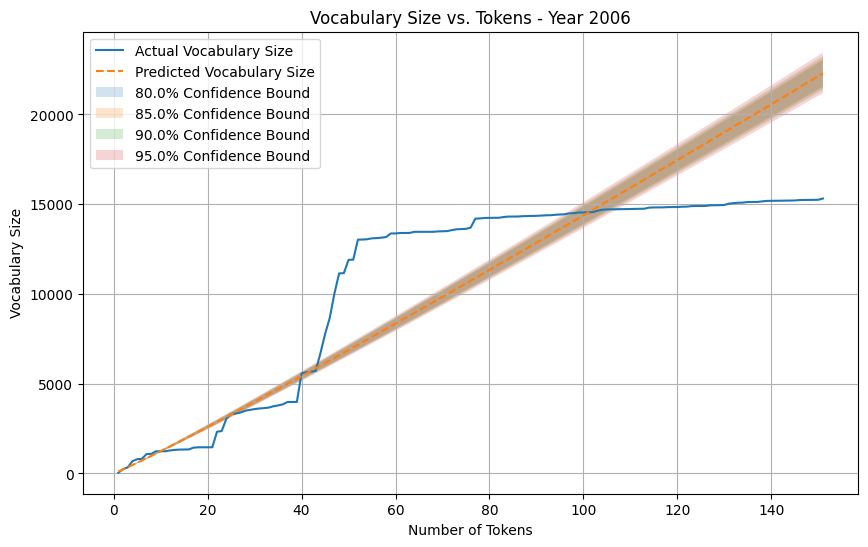

2006 plot done!
Year 2007, 80.0% Confidence: 612 points outside bounds
Year 2007, 85.0% Confidence: 605 points outside bounds
Year 2007, 90.0% Confidence: 603 points outside bounds
Year 2007, 95.0% Confidence: 593 points outside bounds


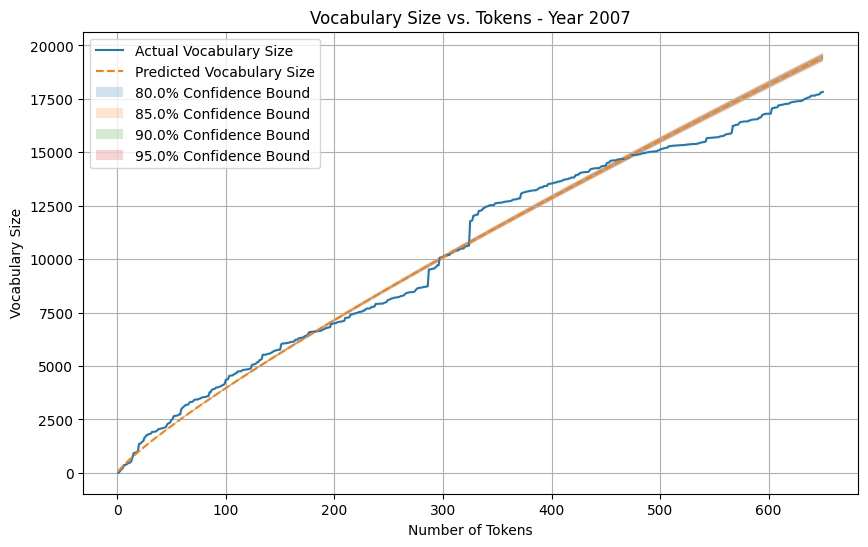

2007 plot done!
Year 2008, 80.0% Confidence: 623 points outside bounds
Year 2008, 85.0% Confidence: 622 points outside bounds
Year 2008, 90.0% Confidence: 617 points outside bounds
Year 2008, 95.0% Confidence: 612 points outside bounds


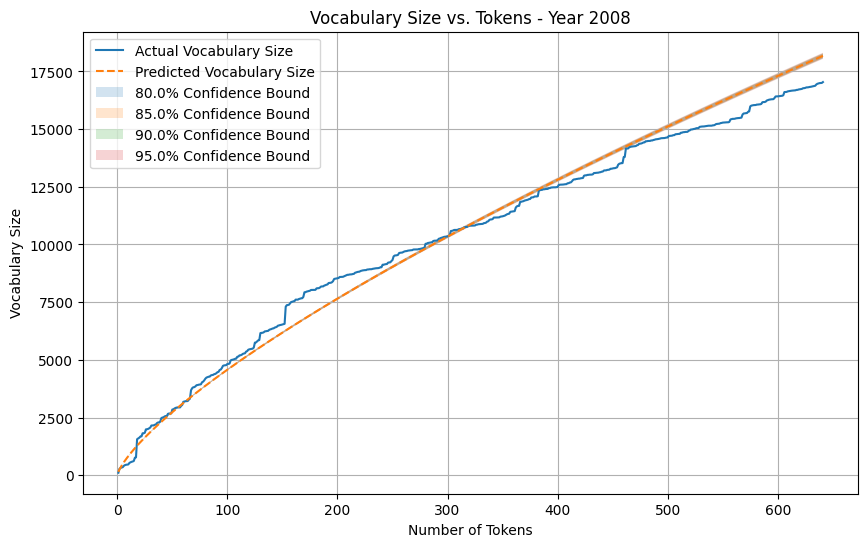

2008 plot done!
Year 2009, 80.0% Confidence: 572 points outside bounds
Year 2009, 85.0% Confidence: 564 points outside bounds
Year 2009, 90.0% Confidence: 559 points outside bounds
Year 2009, 95.0% Confidence: 543 points outside bounds


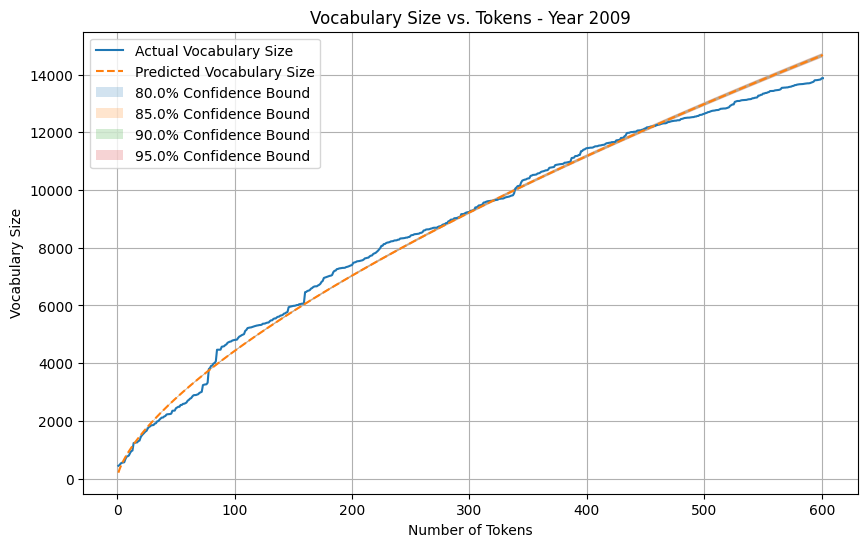

2009 plot done!
Year 2010, 80.0% Confidence: 600 points outside bounds
Year 2010, 85.0% Confidence: 590 points outside bounds
Year 2010, 90.0% Confidence: 584 points outside bounds
Year 2010, 95.0% Confidence: 570 points outside bounds


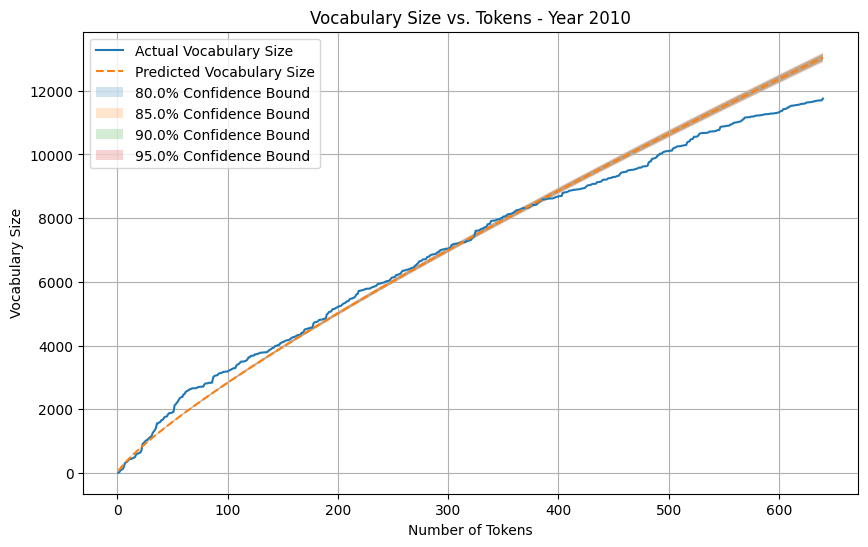

2010 plot done!
Year 2011, 80.0% Confidence: 486 points outside bounds
Year 2011, 85.0% Confidence: 478 points outside bounds
Year 2011, 90.0% Confidence: 473 points outside bounds
Year 2011, 95.0% Confidence: 466 points outside bounds


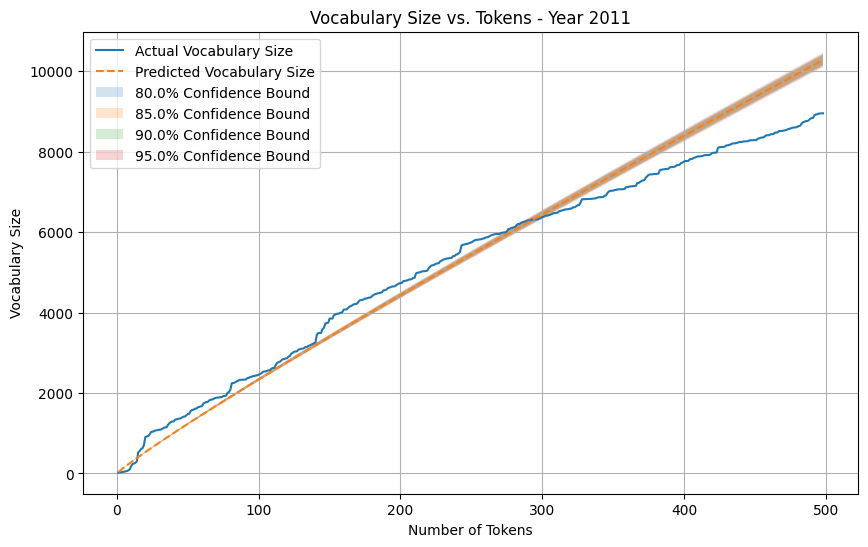

2011 plot done!
Year 2012, 80.0% Confidence: 289 points outside bounds
Year 2012, 85.0% Confidence: 287 points outside bounds
Year 2012, 90.0% Confidence: 282 points outside bounds
Year 2012, 95.0% Confidence: 279 points outside bounds


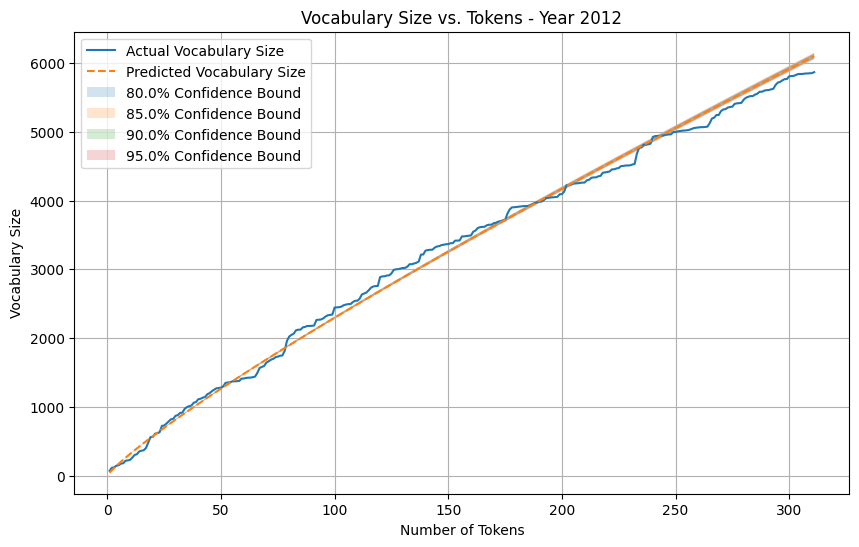

2012 plot done!
Year 2013, 80.0% Confidence: 314 points outside bounds
Year 2013, 85.0% Confidence: 311 points outside bounds
Year 2013, 90.0% Confidence: 307 points outside bounds
Year 2013, 95.0% Confidence: 300 points outside bounds


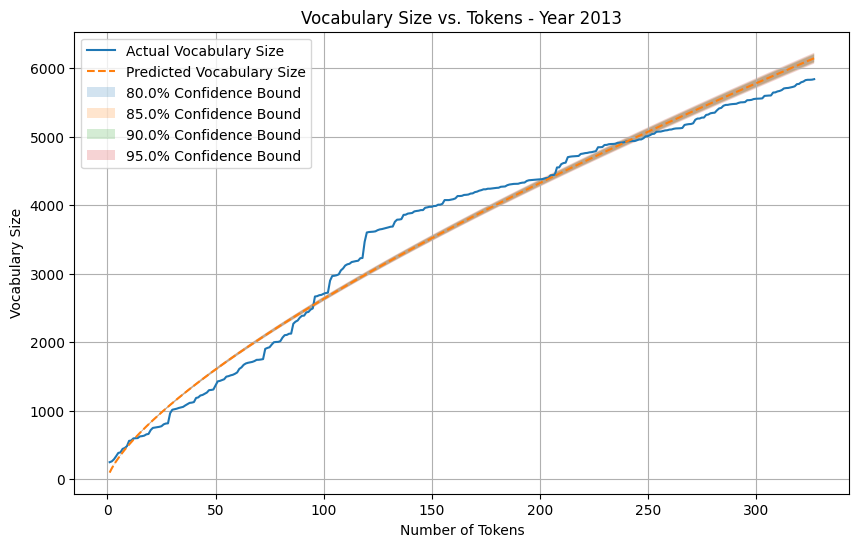

2013 plot done!
Year 2014, 80.0% Confidence: 318 points outside bounds
Year 2014, 85.0% Confidence: 310 points outside bounds
Year 2014, 90.0% Confidence: 299 points outside bounds
Year 2014, 95.0% Confidence: 281 points outside bounds


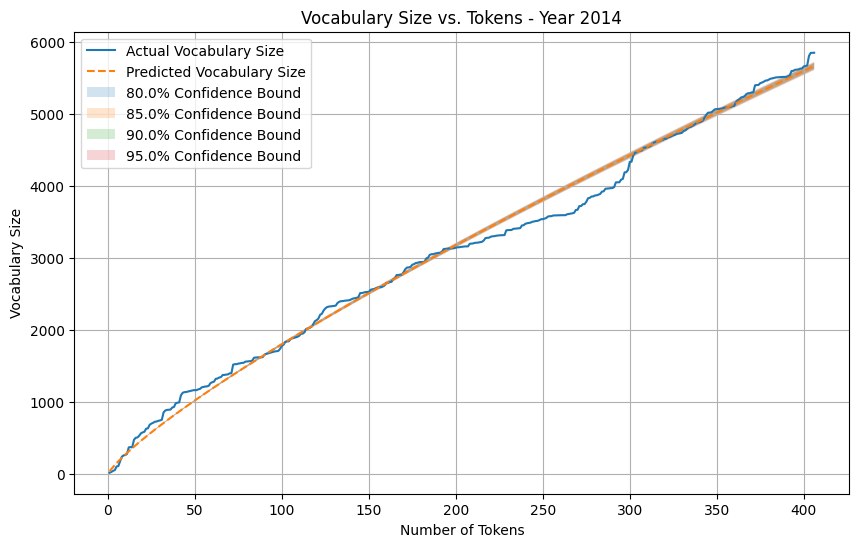

2014 plot done!
Year 2015, 80.0% Confidence: 267 points outside bounds
Year 2015, 85.0% Confidence: 262 points outside bounds
Year 2015, 90.0% Confidence: 260 points outside bounds
Year 2015, 95.0% Confidence: 257 points outside bounds


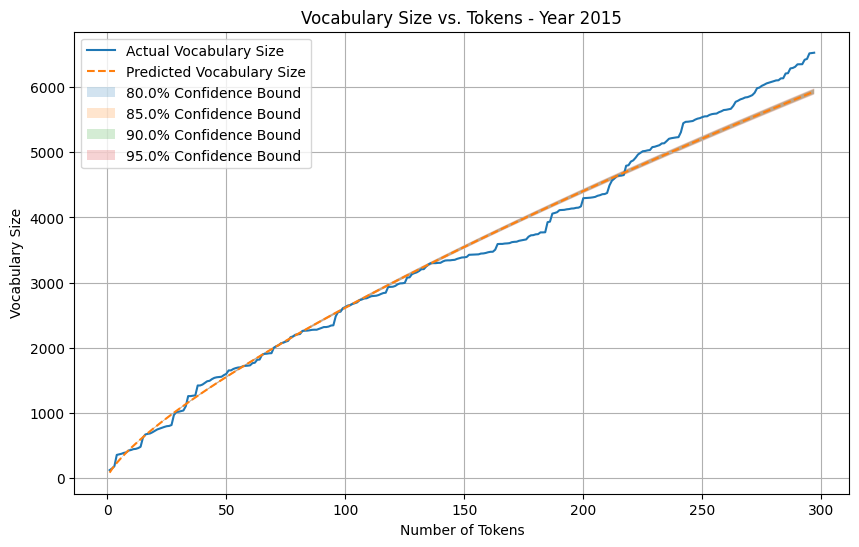

2015 plot done!
Year 2016, 80.0% Confidence: 230 points outside bounds
Year 2016, 85.0% Confidence: 224 points outside bounds
Year 2016, 90.0% Confidence: 222 points outside bounds
Year 2016, 95.0% Confidence: 210 points outside bounds


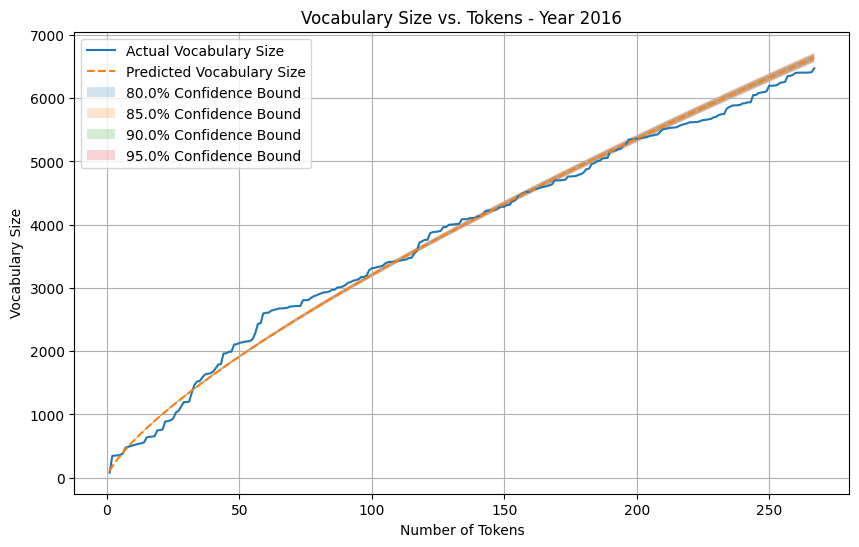

2016 plot done!
Year 2017, 80.0% Confidence: 221 points outside bounds
Year 2017, 85.0% Confidence: 218 points outside bounds
Year 2017, 90.0% Confidence: 216 points outside bounds
Year 2017, 95.0% Confidence: 213 points outside bounds


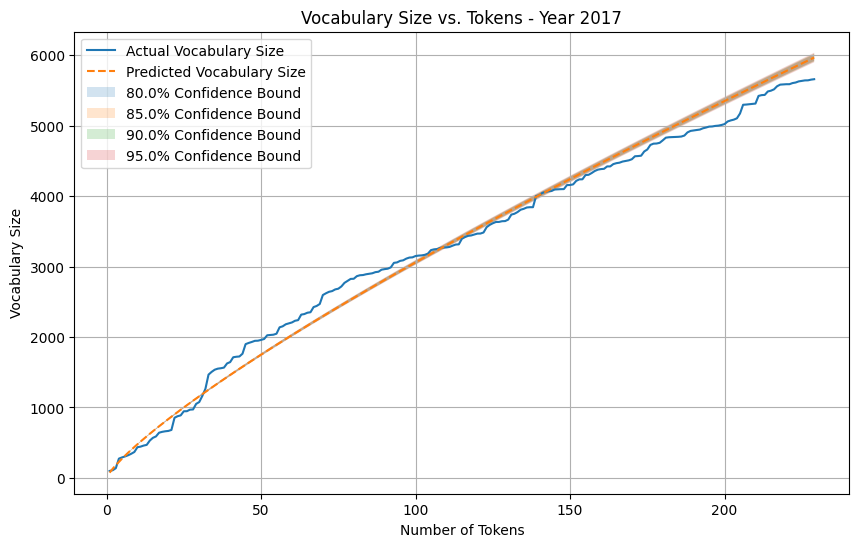

2017 plot done!
Year 2018, 80.0% Confidence: 329 points outside bounds
Year 2018, 85.0% Confidence: 325 points outside bounds
Year 2018, 90.0% Confidence: 313 points outside bounds
Year 2018, 95.0% Confidence: 298 points outside bounds


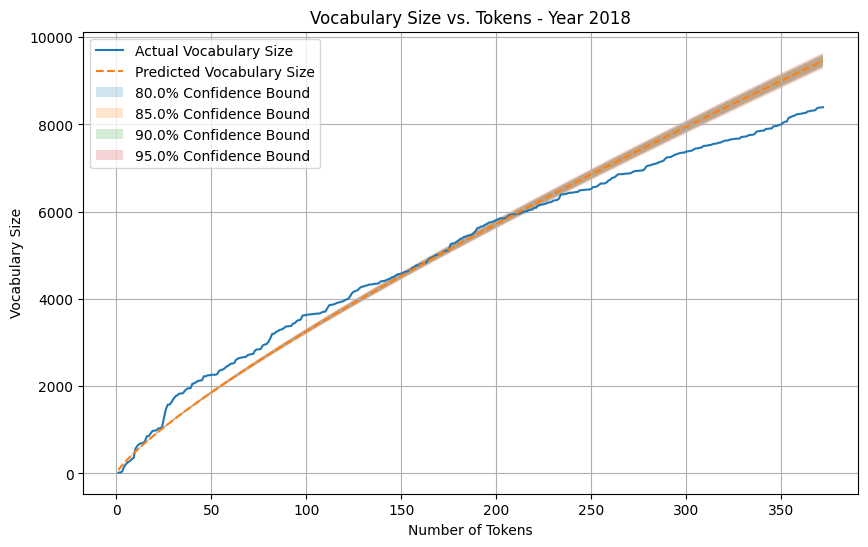

2018 plot done!
Year 2019, 80.0% Confidence: 711 points outside bounds
Year 2019, 85.0% Confidence: 708 points outside bounds
Year 2019, 90.0% Confidence: 706 points outside bounds
Year 2019, 95.0% Confidence: 696 points outside bounds


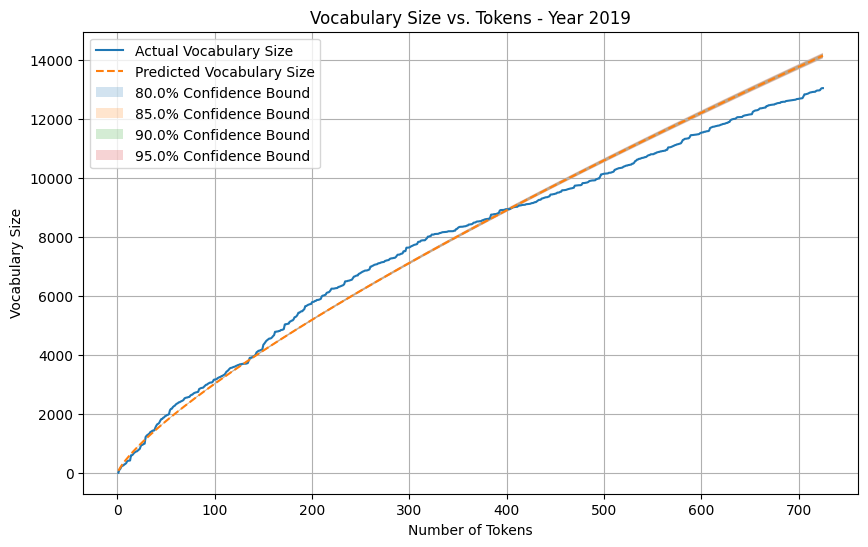

2019 plot done!
Year 2020, 80.0% Confidence: 389 points outside bounds
Year 2020, 85.0% Confidence: 385 points outside bounds
Year 2020, 90.0% Confidence: 381 points outside bounds
Year 2020, 95.0% Confidence: 378 points outside bounds


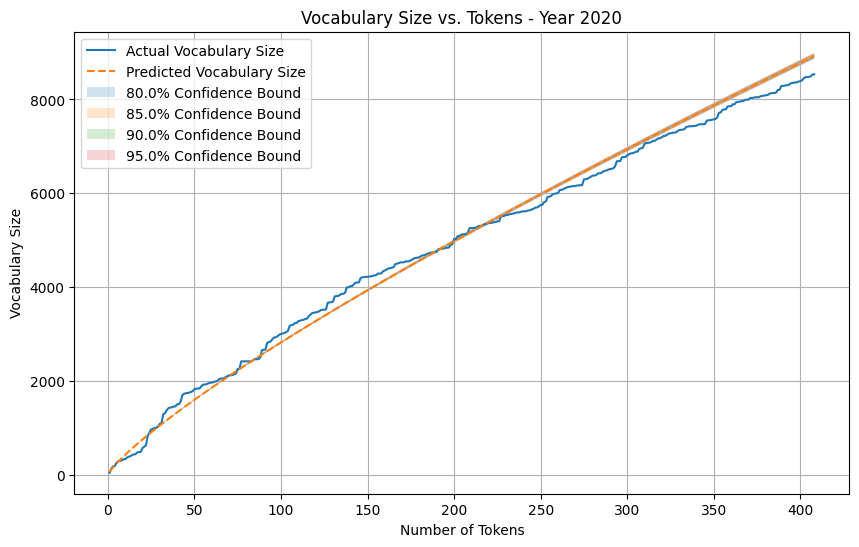

2020 plot done!


In [245]:
#Section 4
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

results = {}
confidence_levels = [0.8, 0.85, 0.9, 0.95]


# Loop for each year
for year, data in yearly_datasets.items():
    tokens = []
    vocab_sizes = []
    text_v = {}
    # if year!='2001':
    #     vocabulary_by_year[year] = 0
    #     continue

    for text in data['thread_text']:
        text = str(text)
        get_vocab_temp = dict(get_vocabulary([text]).vocabulary_.items())
        text_v = {k: text_v.get(k, 0) + get_vocab_temp.get(k, 0) for k in set(text_v) | set(get_vocab_temp)}
        vocab_sizes.append(len(text_v.keys()))
        tokens.append(sum(text_v.values()))
        # if isinstance(text, str):
        #     tokenized = word_tokenize(text)
        #     tokens.extend(tokenized)
        #     vocab_sizes.append(len(set(tokens)))

    # Check if there is data for this year
    if not tokens :
        continue

    # Create a dictionary to store the vocabulary for each year
    vocabulary_by_year = {}
    tokens_by_year = {}

    year_vocabulary = get_vocabulary(data['thread_text'])
    total_unique_vocab = len(year_vocabulary.vocabulary_.keys())
    total_vocab_size = sum(year_vocabulary.vocabulary_.values())
    vocabulary_by_year[year] = total_unique_vocab
    tokens_by_year[year] = total_vocab_size


    # Linear regression (Heaps law)
    x = np.arange(1, len(vocab_sizes) + 1) 

    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(vocab_sizes))

    predicted_vocab_sizes = np.exp(slope * np.log(x) + intercept)

    # Calculate the upper and lower bounds based on  confidence level
    bounds = []
    for confidence in confidence_levels:
        n = len(tokens)
        t = stats.t.ppf(1 - (1 - confidence) / 2, n - 2)
        prediction_interval = t * std_err * np.sqrt(1 + 1 / n + (np.log(x) - np.mean(np.log(x))) ** 2 / ((n - 1) * np.var(np.log(x))))
        upper_bound = predicted_vocab_sizes * np.exp(prediction_interval)
        lower_bound = predicted_vocab_sizes / np.exp(prediction_interval)
        bounds.append((upper_bound, lower_bound))

    results[year] = {
        'tokens': tokens,
        'vocab_sizes': vocab_sizes,
        'predicted_vocab_sizes': predicted_vocab_sizes,
        'confidence_bounds': bounds
    }
    print(f"{year} data processing for ploting done!")

# Plot graphs - years 
for year, data in results.items():
    # if year!='2001':
    #     vocabulary_by_year[year] = 0
    #     continue
    plt.figure(figsize=(10, 6))
    x = np.arange(1, len(data['vocab_sizes']) + 1)  
    plt.plot(x, data['vocab_sizes'], label='Actual Vocabulary Size')
    plt.plot(x, data['predicted_vocab_sizes'], label='Predicted Vocabulary Size', linestyle='--')
    for i, confidence in enumerate(confidence_levels):
        plt.fill_between(x, data['confidence_bounds'][i][0], data['confidence_bounds'][i][1], alpha=0.2, label=f'{confidence*100}% Confidence Bound')
    plt.title(f'Vocabulary Size vs. Tokens - Year {year}')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Vocabulary Size')
    plt.legend()
    plt.grid(True)

    # Count points outside the bounds for each confidence level
    for i, confidence in enumerate(confidence_levels):
        upper_bound = data['confidence_bounds'][i][0]
        lower_bound = data['confidence_bounds'][i][1]
        outside_bounds = sum((data['vocab_sizes'] > upper_bound) | (data['vocab_sizes'] < lower_bound))
        print(f"Year {year}, {confidence*100}% Confidence: {outside_bounds} points outside bounds")

    plt.show()
    print(f"{year} plot done!")




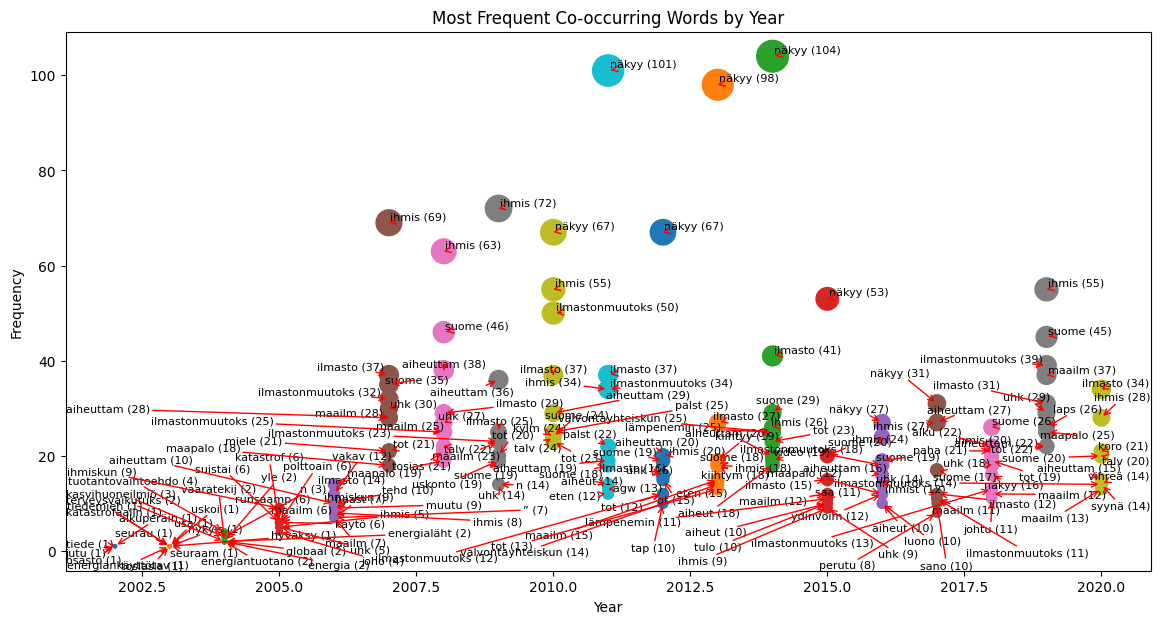

In [246]:
#Section 5

import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

# nltk.download('punkt')

keyword = translations[0]

df = pd.read_csv('data/filtered_threads_f3.csv')

# Convert the 'datetime' column to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'])
df.dropna(inplace=True, how='any')

# Function - find the most frequent co-occurring words
def find_most_frequent_co_occurring_words(data, keyword):
    tokens = word_tokenize(data['thread_text'].str.cat(sep=' '))
    keyword_indices = [i for i, token in enumerate(tokens) if token == keyword]

    # Initialize a FreqDist
    fdist = FreqDist()
    # Define the window size (3 units)
    window_size = 3

    for keyword_index in keyword_indices:
        window_start = max(0, keyword_index - window_size)
        window_end = min(len(tokens), keyword_index + window_size + 1)
        window_words = tokens[window_start:window_end]
        fdist.update(window_words)

    # Exclude the keyword itself
    del fdist[keyword]

    # Get the 10 most frequent words
    top_words = fdist.most_common(10)

    return top_words

# Initialize a dictionary to store the results
results = {}

for year in range(2001, 2021): 
    year_data = df[df['datetime'].dt.year == year]
    top_words = find_most_frequent_co_occurring_words(year_data, keyword)
    results[year] = top_words

# Plot
plt.figure(figsize=(14, 7))
texts = []
for year, top_words in results.items():
    if top_words:
        x, y = zip(*top_words)
        x = [year] * len(x)  # Make x a list of the same year value
        sizes = [freq * 5 for freq in y]  # Scale sizes for visibility
        plt.scatter(x, y, s=sizes)
        for i, (word, freq) in enumerate(top_words):
            texts.append(plt.text(x[i], y[i], f'{word} ({freq})', fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Most Frequent Co-occurring Words by Year')
plt.show()

# Save results to a text file
with open('co_occurring_words.txt', 'w', encoding='utf-8') as file:
    file.write(f"Keyword: {keyword}\n")
    for year, top_words in results.items():
        file.write(f"Year: {year}\n")
        for word, freq in top_words:
            file.write(f"{word}: {freq}\n")
        file.write("\n")  # Add an empty line for better readability
    file.write("====================================\n")  # Separator between keywords



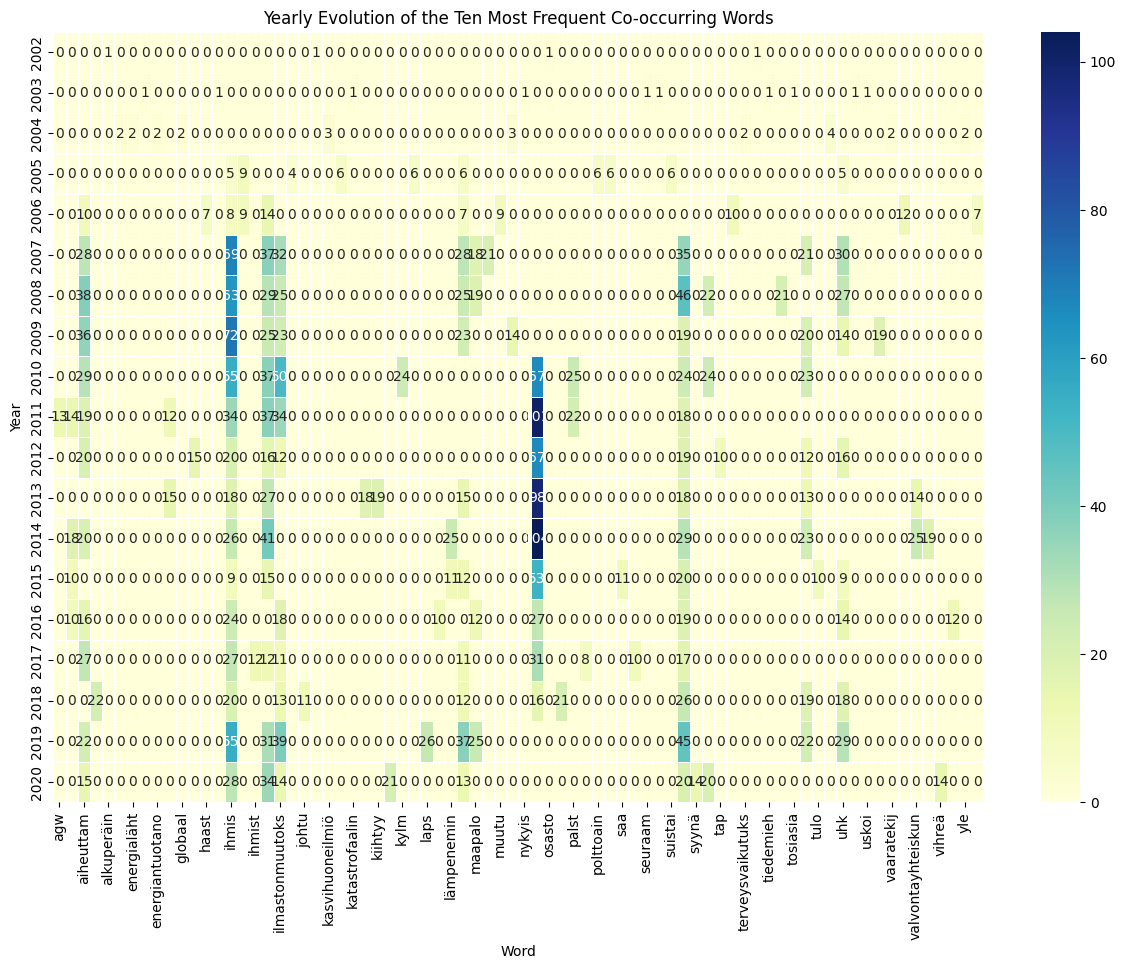

In [247]:
#Section 6

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten the results and create a DataFrame
data = []
for year, top_words in results.items():
    for word, freq in top_words:
        data.append({'Year': year, 'Word': word, 'Frequency': freq})

df_heatmap = pd.DataFrame(data)

# Pivot the DataFrame to get words as columns, years as rows, and frequencies as values
heatmap_data = df_heatmap.pivot(index='Year', columns='Word', values='Frequency')

# Fill NaN values with 0 if any, since not all words may appear every year
heatmap_data = heatmap_data.fillna(0)

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", linewidths=.5, cmap="YlGnBu")

# Set the title and show the plot
plt.title('Yearly Evolution of the Ten Most Frequent Co-occurring Words')
plt.show()

# Save the heatmap data to a CSV file 
heatmap_data.to_csv('yearly_evolution_heatmap.csv')


In [248]:
#Section 7
import pandas as pd
import nltk
nltk.download('punkt')

# Load the dataset
df = pd.read_csv('data/filtered_threads_f3.csv')

# Convert the 'datetime' column to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'])
df.dropna(inplace=True, how='any')

# Function to calculate the number of tokens in the discussion part of a thread
def count_tokens_in_discussion(text):
    # Ensure the text is a string
    if isinstance(text, str):
        # Split the text into tokens and count them
        tokens = nltk.word_tokenize(text)
        return len(tokens)
    else:
        return 0  # Return 0 if the text is not a string

# Initialize a dictionary to store the discussion scores for each year
discussion_scores = {year: [] for year in range(2001, 2021)}

# Loop through the dataset
for index, row in df.iterrows():
    year = row['datetime'].year
    discussion_title = row['title']
    discussion_part = row['thread_text']
    discussion_score = count_tokens_in_discussion(discussion_part)
    discussion_scores[year].append((discussion_title, discussion_part, discussion_score))

# Sort and rank the threads based on the discussion score
for year in discussion_scores:
    discussion_scores[year].sort(key=lambda x: x[2], reverse=True)

# Save the top-ranked threads to a separate database file and add your own perceptions
top_threads = {}
for year in discussion_scores:
    top_threads[year] = discussion_scores[year][:5]  # Get the top 5 threads for each year

# Save the top-ranked threads and your own perceptions to a database file
with open('top_ranked_threads_and_perceptions.txt', 'w', encoding='utf-8') as file:
    for year, threads in top_threads.items():
        if threads:  # Check if there are threads for the year
            file.write(f"Year: {year}\n")
            for title, thread, score in threads:
                file.write(f"Discussion Score: {score}\n")
                file.write(f"Thread Title: {title}\n")
                file.write(f"Thread text: {thread}\n")
                # Add your own perception for each thread here
                file.write("Our Perception: []\n")
                file.write("\n")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aghaffar23\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [249]:
#Section 8

import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaModel
import openpyxl
from openpyxl import Workbook

# Loading the dataset
df = pd.read_csv('data/filtered_threads_f3.csv')

# Convert the 'datetime' column to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'])
df.dropna(inplace=True, how='any')

# Function to preprocess and tokenize text
def preprocess_text(text):
    if isinstance(text, str):
        # Preprocessing was done before, now only tokenizing
        tokens = gensim.utils.simple_preprocess(text)
        return tokens
    else:
        # Handling missing or invalid text data
        return []

# Preparing data for topic modeling
documents_by_year = {}  # Separating documents for each year
for year in range(2001, 2021):
    year_data = df[df['datetime'].dt.year == year]
    documents = [preprocess_text(thread) for thread in year_data['title'] + ' ' + year_data['thread_text']]
    documents_by_year[year] = documents

# Creating a dictionary and a corpus
dictionary_by_year = {}  # Separating dictionary for each year
corpus_by_year = {}  # Separating corpus for each year

for year, documents in documents_by_year.items():
    dictionary = corpora.Dictionary(documents)
    dictionary.filter_extremes(no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in documents]
    dictionary_by_year[year] = dictionary
    corpus_by_year[year] = corpus
    

# Performing LDA topic modeling for each year
num_topics = 2
num_keywords = 5
lda_models = {}  # Separating LDA models for each year
for year, corpus in corpus_by_year.items():
    if len(corpus)<3:
        print(f"Corpus for year {year} is empty, skipping...")
        continue

    # LDA modeling for non-empty corpus
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary_by_year[year], passes=25)
    lda_models[year] = lda_model

# Function to get the top keywords for each topic
def get_topic_keywords(lda_model, num_keywords=5):
    topic_keywords = []
    for i, topic in lda_model.show_topics(formatted=True, num_topics=2, num_words=num_keywords):
        topic_keywords.append(f"{topic}")
    return topic_keywords

# Creating an Excel workbook to store the results
workbook = Workbook()
worksheet = workbook.active

# Adding headers to the Excel table
headers = ["Year", "Topic 1 Keywords", "Topic 2 Keywords"]
worksheet.append(headers)

# Populate the Excel table with topic modeling results for each year
for year in range(2001, 2021):
    lda_model = lda_models.get(year)
    if lda_model:
        topic_keywords = get_topic_keywords(lda_model, num_keywords)
        row_data = [year] + [topic_keywords[0]] + [topic_keywords[1]]
        worksheet.append(row_data)

# Save the results to an Excel file
workbook.save("topic_modeling_results.xlsx")

print("Topic modeling results have been saved to 'topic_modeling_results.xlsx'.")


Corpus for year 2001 is empty, skipping...
Corpus for year 2002 is empty, skipping...
Corpus for year 2003 is empty, skipping...
Topic modeling results have been saved to 'topic_modeling_results.xlsx'.


In [256]:
#Section 9/10

import pandas as pd
from afinn_1 import Afinn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models
import openpyxl
from openpyxl import Workbook

df = pd.read_csv('data/filtered_threads_f3.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.dropna(inplace=True, how='any')

# Create an AFINN sentiment analyzer for Finnish language
afinn = Afinn(language='fi')

# Function to classify text based on sentiment
def classify_sentiment(text):
    sentiment_score = afinn.score(text)
    if sentiment_score >= 0:
        return 'positive'
    else:
        return 'negative'

# Create separate dataframes for positive and negative sentiments
df['sentiment'] = (df['title'] + ' ' + df['thread_text']).apply(classify_sentiment)
positive_df = df[df['sentiment'] == 'positive']
negative_df = df[df['sentiment'] == 'negative']

# Group positive and negative sentiments by year and concatenate statements
positive_statements = positive_df.groupby(positive_df['datetime'].dt.year)['thread_text'].apply(lambda x: [preprocess_text(text) for text in x]).reset_index()
negative_statements = negative_df.groupby(negative_df['datetime'].dt.year)['thread_text'].apply(lambda x: [preprocess_text(text) for text in x]).reset_index()

# Preparing data for topic modeling
def prepare_documents(statements):
    documents_by_year = {}
    for index, row in statements.iterrows():
        year = row['datetime']
        documents_by_year[year] = row['thread_text']
    return documents_by_year

# Prepare documents for positive and negative sentiments
positive_documents_by_year = prepare_documents(positive_statements)
negative_documents_by_year = prepare_documents(negative_statements)

# Function to perform LDA topic modeling
def perform_lda(documents_by_year):
    lda_models = {}
    for year, documents in documents_by_year.items():

        dictionary = corpora.Dictionary(documents)
        dictionary.filter_extremes(no_above=0.5)
        corpus = [dictionary.doc2bow(text) for text in documents]
        if len(corpus)<4:
            print(f"Corpus for year {year} is empty, skipping...")
            lda_models[year] = []
            continue
        lda_model = models.LdaModel(corpus, num_topics=2, id2word=dictionary, passes=25)
        lda_models[year] = lda_model
    return lda_models

# Perform LDA topic modeling for positive and negative sentiments
positive_lda_models = perform_lda(positive_documents_by_year)
negative_lda_models = perform_lda(negative_documents_by_year)

# Creating an Excel workbook to store the results
workbook = Workbook()
positive_sheet = workbook.create_sheet(title="Positive Sentiment")
negative_sheet = workbook.create_sheet(title="Negative Sentiment")

# Adding headers to the Excel sheets
headers = ["Year", "Topic 1 Keywords", "Topic 2 Keywords"]
positive_sheet.append(headers)
negative_sheet.append(headers)

# Populate the Excel sheets with topic modeling results for each year
for year in range(2001, 2021):
    if year in positive_lda_models:
        if positive_lda_models[year]:
            topic_keywords = get_topic_keywords(positive_lda_models[year])
            row_data = [year] + [topic_keywords[0]] + [topic_keywords[1]]
            positive_sheet.append(row_data)
    if year in negative_lda_models:
        if negative_lda_models[year]:
            topic_keywords = get_topic_keywords(negative_lda_models[year])
            row_data = [year] + [topic_keywords[0]] + [topic_keywords[1]]
            negative_sheet.append(row_data)

# Save the results to an Excel file
workbook.save("sentiment_topic_modeling_results.xlsx")

print("Sentiment topic modeling results have been saved to 'sentiment_topic_modeling_results.xlsx'.")


Corpus for year 2002 is empty, skipping...
Corpus for year 2003 is empty, skipping...
Corpus for year 2003 is empty, skipping...
Corpus for year 2004 is empty, skipping...
Sentiment topic modeling results have been saved to 'sentiment_topic_modeling_results.xlsx'.


In [261]:
# section 11 - doing topic modeling with NMF instead of LDA
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from openpyxl import Workbook
import gensim

# Load Finnish stopwords from a text file
with open('finnish_stopwords.txt', 'r', encoding='utf-8') as f:
    finnish_stopwords = f.read().splitlines()

# Loading the dataset
df = pd.read_csv('data/filtered_threads_f3.csv')

# Convert the 'datetime' column to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'])
df.dropna(inplace=True, how='any')

# Function to preprocess and tokenize text
def preprocess_text(text):
    if isinstance(text, str):
        # Preprocessing was done before, now only tokenizing
        tokens = gensim.utils.simple_preprocess(text)
        return tokens
    else:
        # Handling missing or invalid text data
        return []

# Preparing data for topic modeling
documents_by_year = {}  # Separating documents for each year
for year in range(2005, 2021):
    year_data = df[df['datetime'].dt.year == year]
    documents = [preprocess_text(thread) for thread in year_data['title'] + ' ' + year_data['thread_text']]
    documents_by_year[year] = documents

# Vectorization and NMF for each year
num_topics = 2
num_topics_keywords = 5
nmf_models = {}
tfidf_vectorizer_by_year = {}
nmf_topic_keywords = {}

for year, documents in documents_by_year.items():
    # Combine documents into a single string per year
    text_data = [" ".join(doc) for doc in documents]
    # Create TF-IDF vectors using Finnish stopwords
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=finnish_stopwords)
    tfidf = tfidf_vectorizer.fit_transform(text_data)
    tfidf_vectorizer_by_year[year] = tfidf_vectorizer
    
    # Check if there is enough data to fit NMF
    if tfidf.shape[0] < num_topics:
        print(f"Not enough data to fit NMF for year {year}, skipping...")
        continue
    
    # Fit the NMF model
    nmf_model = NMF(n_components=num_topics, random_state=1).fit(tfidf)
    nmf_models[year] = nmf_model
    
    # Get the topics
    for topic_idx, topic in enumerate(nmf_model.components_):
        topic_keywords = " ".join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-num_topics_keywords - 1:-1]])
        nmf_topic_keywords.setdefault(year, []).append(topic_keywords)

# Creating an Excel workbook to store the results
workbook = Workbook()
worksheet = workbook.active

# Adding headers to the Excel table
headers = ["Year"] + [f"Topic {i+1} Keywords" for i in range(num_topics)]
worksheet.append(headers)

# Populate the Excel table with topic modeling results for each year
for year, keywords in nmf_topic_keywords.items():
    row_data = [year] + keywords
    worksheet.append(row_data)

# Save the results to an Excel file
workbook.save("nmf_topic_modeling_results.xlsx")

print("NMF topic modeling results have been saved to 'nmf_topic_modeling_results.xlsx'.")


NMF topic modeling results have been saved to 'nmf_topic_modeling_results.xlsx'.
